<a href="https://colab.research.google.com/github/ProtimGanguly/Churn_Prediction/blob/master/Churn_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
#!pip install tensorflow==2.0.0-alpha0
import csv 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
import plotly.express as ex
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, roc_curve
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

In [3]:
#This section has been introduced to upload the file in cache to read
from google.colab import files
uploaded = files.upload()

Saving WA_Fn-UseC_-Telco-Customer-Churn.csv to WA_Fn-UseC_-Telco-Customer-Churn (1).csv


In [0]:
churn_data = pd.read_csv("WA_Fn-UseC_-Telco-Customer-Churn.csv")
chrn_data = churn_data

In [5]:
chrn_data.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


## Data Preprocessing

In [6]:
# Analyzing the data types of the dataset to check for compatible types
print(churn_data.dtypes)
#TotalCharges column has data type of object. Since it is a numerical value, we can convert this to a numeric type.
churn_data['TotalCharges'] = pd.to_numeric(churn_data['TotalCharges'], errors='coerce')

customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


### Check missing values as percentage

Text(0.5, 1.0, 'Percent missing data by feature')

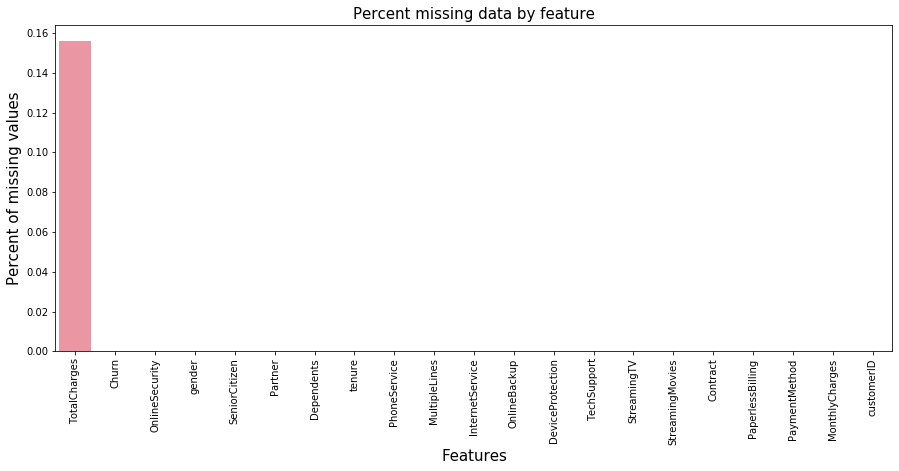

In [7]:
# Check the missing values percentage
total = churn_data.isnull().sum().sort_values(ascending=False)
percent = ((churn_data.isnull().sum()/churn_data.isnull().count())*100).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
#print(missing_data)
f, ax = plt.subplots(figsize=(15, 6))
plt.xticks(rotation='90')
sns.barplot(x=missing_data.index, y=missing_data['Percent'])
plt.xlabel('Features', fontsize=15)
plt.ylabel('Percent of missing values', fontsize=15)
plt.title('Percent missing data by feature', fontsize=15)

In [8]:
# From the above plot it can be seen that only Total Charges feature has missing values. Since the percentage of missing values
# is only 0.16 for Total Charges so I have proceeded with removing those rows instead of imputing them using other methods.
#churn_data.dropna(inplace=True)
churn_data = churn_data.dropna().reset_index(drop=True)
print(churn_data.isnull().sum())

customerID          0
gender              0
SeniorCitizen       0
Partner             0
Dependents          0
tenure              0
PhoneService        0
MultipleLines       0
InternetService     0
OnlineSecurity      0
OnlineBackup        0
DeviceProtection    0
TechSupport         0
StreamingTV         0
StreamingMovies     0
Contract            0
PaperlessBilling    0
PaymentMethod       0
MonthlyCharges      0
TotalCharges        0
Churn               0
dtype: int64


In [0]:
# Now the goal is to predict whether the customers left the telco service or they were retained. The features pertaining to the
# customers account information, their service and demographic information seems useful. The feature 'CustomerID' doesnt have any
# relevant information for such prediction. Hence dropping that column.
churn_data = churn_data.drop(["customerID"], axis = 1)

### Exploratory Analysis

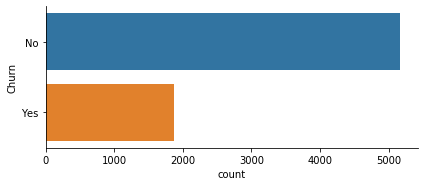

In [10]:
# Here we can see that the number of customers left the company vs number of customers retained is unbalanced. This shows that our
# data is skewed and the skewness needs to be handled.
target_plt = sns.catplot(y="Churn", kind="count", data=churn_data, height=2.5, aspect=2.4, orient='h')

In [0]:
# Next converting our categorical target 'Churn' to numerical which can be used in deep learning algorithms.
churn_data['Churn'] = churn_data['Churn'].map( {'No': 0, 'Yes': 1} ).astype(int)

Gender vs Churn

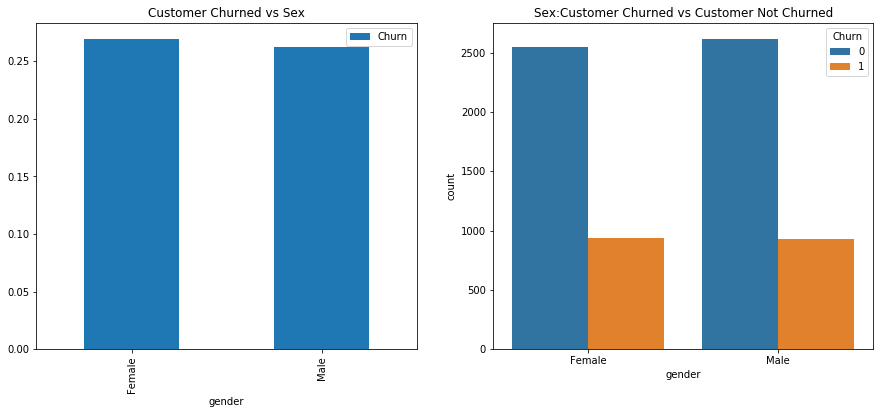

In [12]:
# We can see from below data that almost same number of customers regardless of gender have been churned/ not churned
# in the previous month
f,ax=plt.subplots(1,2,figsize=(15,6))
churn_data[['gender','Churn']].groupby(['gender']).mean().plot.bar(ax=ax[0])
ax[0].set_title('Customer Churned vs Sex')
sns.countplot('gender',hue='Churn',data=churn_data,ax=ax[1])
ax[1].set_title('Sex:Customer Churned vs Customer Not Churned')
plt.show()

Senior Citizen vs Churn

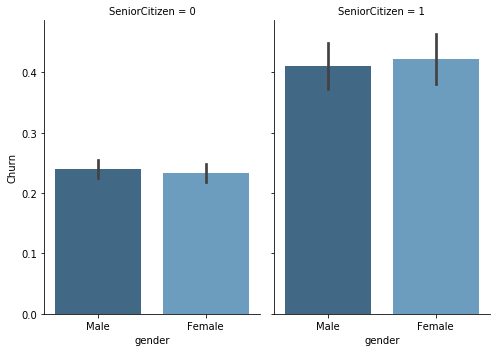

In [13]:
# We can see from below plot that senior citizens on average have a higher percentage to churn. Also the churn rate is equal between
# both the genders.
snrCit = sns.FacetGrid(churn_data, col="SeniorCitizen", height=5, aspect=.7)
snrCit_Gen = snrCit.map(sns.barplot, "gender", "Churn", palette = "Blues_d")

Partner vs Dependants vs Churn

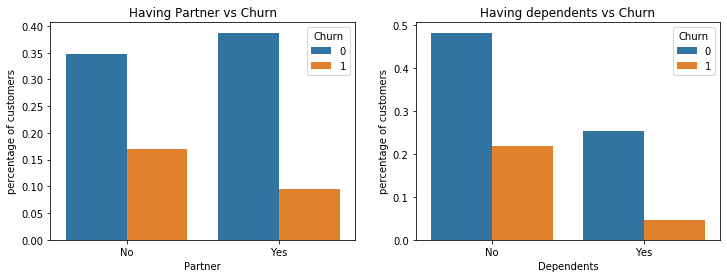

In [14]:
# From the below plot we can see that customers having partners are less likely to churn. Also customer having dependants as well
# are less likely to churn. A hypothesis can be made that below customers are enrolled in certain Family Plans for which below
# trend can be explained.
fig, axis = plt.subplots(1, 2, figsize=(12,4))
axis[0].set_title("Having Partner vs Churn")
axis[1].set_title("Having dependents vs Churn")
yplt = "percentage of customers"
# Plotting Having Partner vs Churn
partner_churn = churn_data.groupby('Partner')["Churn"].value_counts()/len(churn_data)
partner_churn = partner_churn.to_frame().rename({"Churn": yplt}, axis=1).reset_index()
ax = sns.barplot(x='Partner', y= yplt, hue='Churn', data=partner_churn, ax=axis[0])
# Plotting Having dependents vs Churn
dep_churn = churn_data.groupby('Dependents')["Churn"].value_counts()/len(churn_data)
dep_churn = dep_churn.to_frame().rename({"Churn": yplt}, axis=1).reset_index()
ax = sns.barplot(x='Dependents', y= yplt, hue='Churn', data=dep_churn, ax=axis[1])

Phone Services, Multiple Lines vs Churn

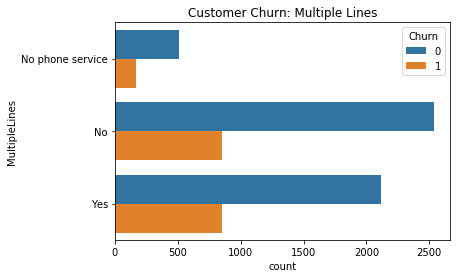

In [15]:
# From below plot we can see that there are very few customers without phone service. Also customers with multiple phone lines
# are slightly more likely to churn.
sns.countplot(y = 'MultipleLines', hue='Churn', data=churn_data)
plt.title('Customer Churn: Multiple Lines')
plt.show()

Internet Service vs Churn

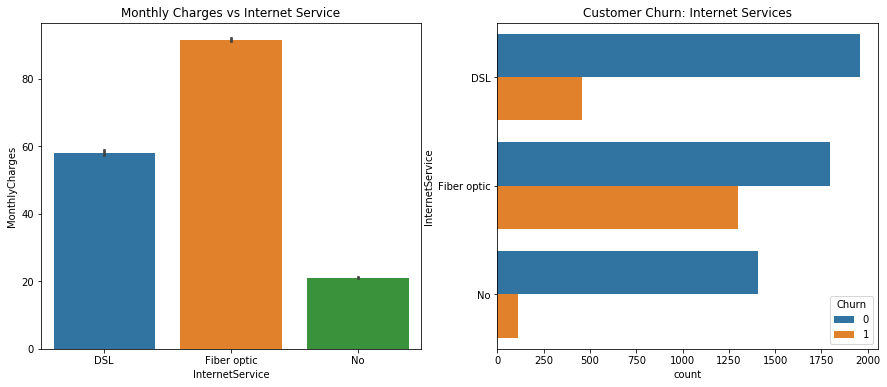

In [16]:
# In this plot we can see that customer with no Internet Service are very less likely to churn. Also it seems that customers having
# Fibre Optic connection are much more likely to churn than customers having DSL connection. We can also see that customers having
# DSL connection have less monthly charges and much lower churn rate so Monthly charges seems to be playing a factor in the churn
# rates.
f,ax=plt.subplots(1,2,figsize=(15,6))
sns.barplot(x='InternetService',y='MonthlyCharges',data=churn_data, ax = ax[0])
ax[0].set_title('Monthly Charges vs Internet Service')
sns.countplot(y = 'InternetService', hue='Churn', data=churn_data)
plt.title('Customer Churn: Internet Services')
plt.show()

Other Services

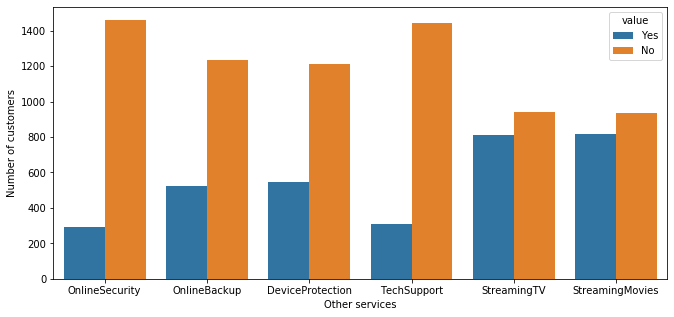

In [17]:
# Filtering out 'No Internet Service' option since without internet other services are not available. Now I wanted to see if the
# Other Services Feature had any relation on the Number of customers churning. From below plot we can see that customer having
# additional services - "OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport" have a lower churn rate than 
# customers having StreamingTV and StreamingMovie services.
cols = ["OnlineSecurity", "OnlineBackup", "DeviceProtection", "TechSupport", "StreamingTV", "StreamingMovies"]
churn_data_other = pd.melt(churn_data[(churn_data["InternetService"] != "No") & (churn_data["Churn"] == 1)][cols])
#churn_data_other.head(30)
plt.figure(figsize=(11, 5))
cplot = sns.countplot(x = 'variable', hue='value', data=churn_data_other)
cplot.set(xlabel='Other services', ylabel='Number of customers')
plt.show()

Contract vs Churn

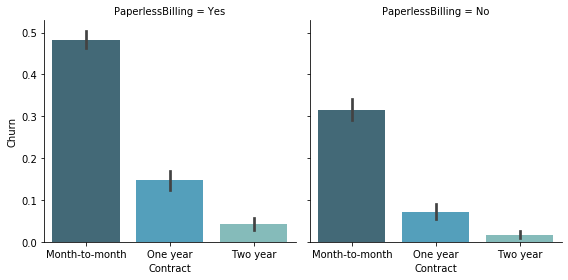

In [18]:
# From below plot we can see that customers who have opted for paperless billing are more likely to churn. Also shorter term
# contracts have a higher churn rate. And Month-to-Month are the majority contracts that this company is losing. An intuition for
# this can be that termination of longer contracts might be accompanied with fines and longer term contract customers are more loyal.
bill_contrt = sns.FacetGrid(churn_data, col="PaperlessBilling", height = 4)
bill_contrt.map(sns.barplot, "Contract", "Churn", palette = "GnBu_d", order= ['Month-to-month', 'One year', 'Two year'])


In [19]:
# From below plot it can be seen that around 88% of the customers that were lost were on a Month-to-Month contract basis. An intuition
# from this might be that the company might make some policy changes to its Month-to-Month contract customers with more lucrative
# offers.
cust_churn = churn_data.loc[churn_data['Churn'] == 1]
cust_churn_count = (cust_churn['Contract']).value_counts(normalize=True) * 100

# create lists of contracts and values
cntrt_type = cust_churn_count.keys().tolist()
percent = cust_churn_count.values.tolist()

fig = go.Figure(data=[go.Pie(
    labels=cntrt_type, 
    values=percent)])

fig.update_layout(
    title_text = 'Percentages of Contract Types'
)
fig.show()

Contract vs Monthly Charges

In [20]:
# To do some cost analysis I have investigated the average monthly costs of customers across various contracts to determine if the
# cost played some role in the churning. From below plot we can see a trend that higher monthly paying customers are 
# actually churning. So there is a relationship between higher monthly charges and the churn rate.

fig = ex.histogram(chrn_data, x="Churn", y="MonthlyCharges", histfunc="avg", color='Churn',facet_col="Contract")
fig.update_layout(title_text='Average Monthly Charges vs Contract Type')
fig.show()

Churn vs Total Charges

Text(0.5, 1.0, 'Distribution of total charges vs churn')

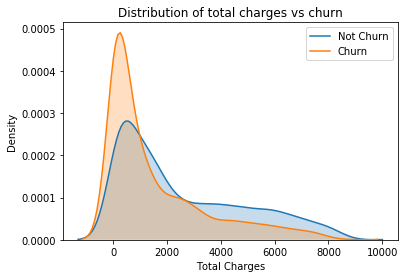

In [21]:
# Also from below plot we can see that customers having lower total charges are more likely to churn. So from this a hypothesis can
# be made that customers who tend to have a higher investment in the company turns out to be more loyal.
ax = sns.kdeplot(churn_data.TotalCharges[(churn_data["Churn"] == 0) ],shade = True)
ax = sns.kdeplot(churn_data.TotalCharges[(churn_data["Churn"] == 1) ],ax =ax, shade= True)
ax.legend(["Not Churn","Churn"])
ax.set_ylabel('Density')
ax.set_xlabel('Total Charges')
ax.set_title('Distribution of total charges vs churn')

##Feature Engineering

Cleaning Categorical Features

In [0]:
# Based on the EDA above we have seens that gender is not a good feature for predicting the churning rate of customers. Also
# Streaming Movie and Streaming TV are not good predictors for the churning rate of customers based on the EDA. Hence proceeding with
# dropping those features.
churn_data = churn_data.drop(['gender', 'StreamingTV', 'StreamingMovies'], axis=1)

# Also when there is 'No' Phone Service then Multiple Lines feature can be converted to 'No' and similarly 'No Internet Service'
# can be converted to 'No' for the same reasons.
churn_data['MultipleLines'] = churn_data['MultipleLines'].map( {'Yes':'Yes', 'No':'No','No phone service' : 'No'} )
churn_data['OnlineSecurity'] = churn_data['OnlineSecurity'].map( {'Yes':'Yes', 'No':'No','No internet service': 'No'} )
churn_data['OnlineBackup'] = churn_data['OnlineBackup'].map( {'Yes':'Yes', 'No':'No','No internet service': 'No'} )
churn_data['DeviceProtection'] = churn_data['DeviceProtection'].map( {'Yes':'Yes', 'No':'No','No internet service': 'No'} )
churn_data['TechSupport'] = churn_data['TechSupport'].map( {'Yes':'Yes', 'No':'No','No internet service': 'No'} )


In [0]:
#Converting Categorical feature Partner to a numerical feature
churn_data['Partner'] = churn_data['Partner'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature Dependants to a numerical feature
churn_data['Dependents'] = churn_data['Dependents'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature Phone Service to a numerical feature
churn_data['PhoneService'] = churn_data['PhoneService'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature Multiple Lines to a numerical feature
churn_data['MultipleLines'] = churn_data['MultipleLines'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature Internet Service to a numerical feature
churn_data['InternetService'] = churn_data['InternetService'].map( {'No': 0, 'DSL': 1, 'Fiber optic' : 2} ).astype(int)
#Converting Categorical feature Online Security to a numerical feature
churn_data['OnlineSecurity'] = churn_data['OnlineSecurity'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature Online Backup to a numerical feature
churn_data['OnlineBackup'] = churn_data['OnlineBackup'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature DeviceProtection to a numerical feature
churn_data['DeviceProtection'] = churn_data['DeviceProtection'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature TechSupport to a numerical feature
churn_data['TechSupport'] = churn_data['TechSupport'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature Contract to a numerical feature
churn_data['Contract'] = churn_data['Contract'].map( {'Month-to-month': 0, 'One year': 1, 'Two year': 2} ).astype(int)
#Converting Categorical feature PaperlessBilling to a numerical feature
churn_data['PaperlessBilling'] = churn_data['PaperlessBilling'].map( {'No': 0, 'Yes': 1} ).astype(int)
#Converting Categorical feature PaymentMethod to a numerical feature
churn_data['PaymentMethod'] = churn_data['PaymentMethod'].map( {'Electronic check': 0, 'Mailed check': 1, 
                                'Bank transfer (automatic)': 2, 'Credit card (automatic)': 3}).astype(int)



Numerical Features Distribution

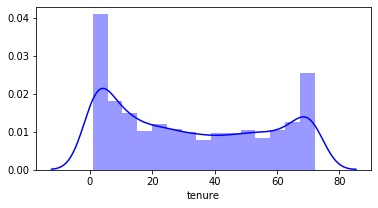

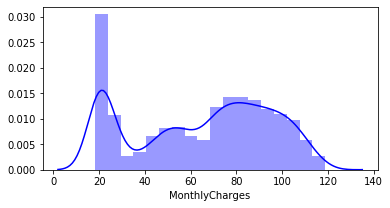

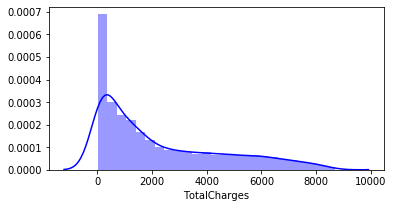

In [24]:
# TENURE - From the below distribution we can see that a lot of customers have contracts with the telecom company for only 
# 1 month, while a good few are there for about 72 months. So it seems different customers have different contracts. 
# MONTHLY & TOTAL CHARGES - From the below plots as well we can see that most of the customers fall in the minimum category of
# monthly and total charges.
cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
for col in cols:
  plt.figure(figsize=(6,3))
  sns.distplot(churn_data[col], color= 'b')

Creating Derived Features

In [0]:
# Here I have created derived features tenure_year by binning the tenure months into years respectively.
churn_data.loc[(churn_data['tenure'] >= 1) & (churn_data['tenure'] <= 12), 'tenure_year'] = 1
churn_data.loc[(churn_data['tenure'] > 12) & (churn_data['tenure'] <= 24), 'tenure_year'] = 2
churn_data.loc[(churn_data['tenure'] > 24) & (churn_data['tenure'] <= 36), 'tenure_year'] = 3
churn_data.loc[(churn_data['tenure'] > 36) & (churn_data['tenure'] <= 48), 'tenure_year'] = 4
churn_data.loc[(churn_data['tenure'] > 48) & (churn_data['tenure'] <= 60), 'tenure_year'] = 5
churn_data.loc[(churn_data['tenure'] > 60) & (churn_data['tenure'] <= 72), 'tenure_year'] = 6
churn_data['tenure_year'] = churn_data['tenure_year'].astype(int)

In [0]:
# Here I have created one more derived features - Charge_Ratio
churn_data['Charge_Ratio'] = ((churn_data['MonthlyCharges']*churn_data['tenure'])/churn_data['TotalCharges']).apply(lambda x: round(x, 2))

In [27]:
churn_data.head()

,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn,tenure_year,Charge_Ratio
0,0,1,0,1,0,0,1,0,1,0,0,0,1,0,29.85,29.85,0,1,1.00
1,0,0,0,34,1,0,1,1,0,1,0,1,0,1,56.95,1889.50,0,3,1.02
2,0,0,0,2,1,0,1,1,1,0,0,0,1,1,53.85,108.15,1,1,1.00
3,0,0,0,45,0,0,1,1,0,1,1,1,0,2,42.30,1840.75,0,4,1.03
4,0,0,0,2,1,0,2,0,0,0,0,0,1,0,70.70,151.65,1,1,0.93


Standardization

In [0]:
# Since the numerical features have different scales we need to standardize/normalize the data we have especially since I have used
# neural network. This will enable the model to converge quickly instead of oscillating back and forth. I have experimented 
# with raw numerical features, normalization and standardization and found standardization has better results.
cols = ['tenure', 'MonthlyCharges', 'TotalCharges','Charge_Ratio']
chrn_num_cols = pd.DataFrame(MinMaxScaler(feature_range = (0,5)).fit_transform(churn_data[cols].astype('float64')),columns=cols)
#Dropping the existing columns
churn_data = churn_data.drop(['tenure', 'MonthlyCharges', 'TotalCharges', 'Charge_Ratio'], axis=1)
#Concating the numerical columns to original dataframe
churn_data = pd.concat([chrn_num_cols, churn_data], axis=1)


In [29]:
churn_data.head()

,tenure,MonthlyCharges,TotalCharges,Charge_Ratio,SeniorCitizen,Partner,Dependents,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,Contract,PaperlessBilling,PaymentMethod,Churn,tenure_year
0,0.000000,0.577114,0.006375,2.222222,0,1,0,0,0,1,0,1,0,0,0,1,0,0,1
1,2.323944,1.925373,1.079333,2.345679,0,0,0,1,0,1,1,0,1,0,1,0,1,0,3
2,0.070423,1.771144,0.051552,2.222222,0,0,0,1,0,1,1,1,0,0,0,1,1,1,1
3,3.098592,1.196517,1.051206,2.407407,0,0,0,0,0,1,1,0,1,1,1,0,2,0,4
4,0.070423,2.609453,0.076650,1.790123,0,0,0,1,0,2,0,0,0,0,0,1,0,1,1


Correlation of Attributes

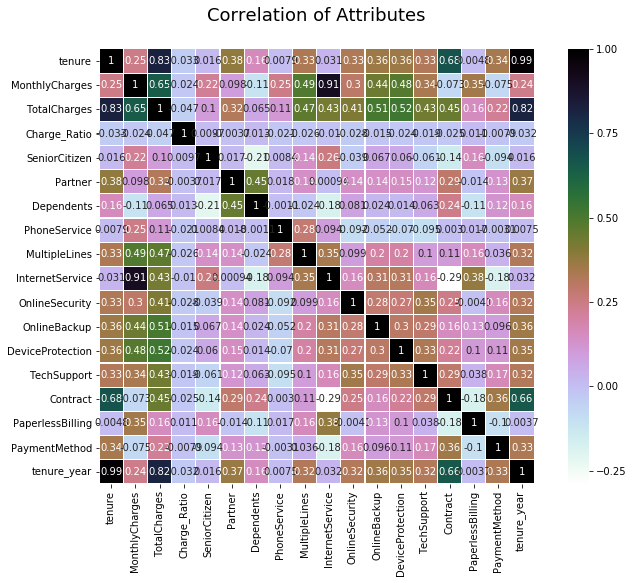

In [30]:
# In order to check if the features are independant of one another and contain unique information which will help the machine
# learning model
plt.figure(figsize=(12,8))
plt.title('Correlation of Attributes', y=1.05, size=18)
sns.heatmap(churn_data.drop(['Churn'], axis=1).astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap='cubehelix_r', linecolor='white', annot=True)

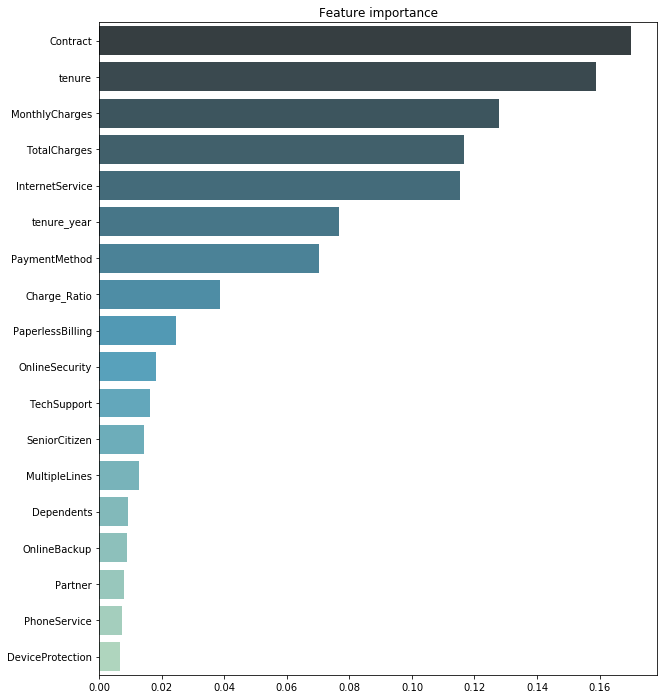

In [31]:
# We see that all our features are important! This a good sign for the machine learning models. From below plot we can see that
# none of the features have zero importance. Contract, Tenure, MonthlyCharges, TotalCharges are most important features.
# Hence I have decided to proceed by using all the features.
hyper_Param = {'random_state': 0, 'n_jobs': 4, 'n_estimators': 5000, 'max_depth': 8}
x, y = churn_data.drop(['Churn'], axis=1), churn_data['Churn']
# Fit RandomForest Classifier
randclassfier = RandomForestClassifier(**hyper_Param)
randclassfier = randclassfier.fit(x, y)
# Plot features importances
rank = pd.Series(data=randclassfier.feature_importances_, index=x.columns).sort_values(ascending=False)
plt.figure(figsize=(10,12))
plt.title("Feature importance")
ax = sns.barplot(y=rank.index, x=rank.values, palette="GnBu_d", orient='h')

##Predictions

Splitting and Cross Validation

In [0]:
# In order to test the performance of my models I have created a separate untouched test set. I have created a validation set with 
# basically 20% of the whole set.
# In order to test the efficiency of my classifier I have splitted the data in a train and test set, to evaluate my model in data 
# that it has never seen before. However, when evaluating different features, transformations and hyperparameters for estimators 
# there might be a risk of overffiting on the test set. To solve this problem, I have another part of the dataset as a held out 
# validation set.

X_test = churn_data.tail(1000).drop(['Churn'], axis=1)
Y_test = churn_data.tail(1000)['Churn']

X = churn_data.iloc[:-1000].drop(['Churn'], axis=1)
y = churn_data.iloc[:-1000]['Churn']
# Creating 20% validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=100)
model_metric_cols =['Classifier','Validation Accuracy']
record = []



####Creating the Model
In tensorflow, I have used a ready-to-use model called an Estimator. The way data is fed into an estimator is using an INPUT_FUNC(). Hence by using an input function we can write our own custom built estimators or pre built ones. This gives the flexibility to change models without changing the way data is processed. Here I have used three pre built estimators to implement ML algorithms - LinearClassfier, DNNClassfier, BoostedTreesClassifier.

In [33]:
# To use an estimator we need to feed to pass it feature columns. A feature column is an entermediate abstractation between the 
# raw data and the estimator. Therefore, it converts a raw data feature into a format that an Estimator can read and act upon.
numeric_columns = []
numeric_features = X_train.select_dtypes(exclude=[np.object])

for feature in numeric_features:
    numeric_columns.append(
        tf.feature_column.numeric_column(
            key=feature
        )
    )

print('Number of numeric features: {}'.format(len(numeric_columns)))

Number of numeric features: 18


Creating the Models

In [0]:
# Here I have created the Estimator model using the numeric columns. 
def create_logistic_model():
    model = tf.estimator.LinearClassifier(
        feature_columns=numeric_columns)
    
    return model

In [0]:
# Here I have created the Estimator DNN model with 3 hidden layers using 18,10,10 neurons in the hidden layers
# along with the numeric columns.
def create_DNN_model():
    DNN_model = tf.estimator.DNNClassifier(hidden_units=[18,10,10], feature_columns=numeric_columns, n_classes=2)
    return DNN_model


In [0]:
# Since our dataset fits into memory, using entire dataset per layer. Here one batch is defined as the entire dataset.
def create_boost_model():
    boostTrees_model = tf.estimator.BoostedTreesClassifier(feature_columns=numeric_columns, n_batches_per_layer = 1)
    
    return boostTrees_model

Estimator Functions

In [0]:
# Here I have created the input function to feed into the estimator. I have used the default pandas input function for TensorFlow
# pandas_input_fn. The pandas_input_fn() function receives below parameters:
# x: The DataFrame with the features.
# y: A Series object with the labels.
# num_epochs: The number of times it will use the whole dataset. None means that it will run indefinetely.
# shuffle: If the dataset will be shuffled.
# I have used the returning object from calling the generator to pass it to the 'train' Estimator object.
batch_size = 64
def train_model(model, x, y, should_shuffle, steps, num_epochs):
    #num_epochs = 2000
    
    model.train(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x=x,
            y=y,
            batch_size=batch_size,
            num_epochs=num_epochs,
            shuffle=should_shuffle
        ), steps = steps)


In [0]:
# Here I have evaluated the model using the validation input function. The evaluate function returns various scoring metrics. 
# In this case I have fetched only the accuracy on the validation set.
def evaluate_model(model, validation_data, validation_targets, should_shuffle, model_flag):
    evaluate_dict = model.evaluate(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x=validation_data,
            y=validation_targets,
            batch_size=batch_size,
            shuffle=should_shuffle
        )
    )
    if(model_flag == 0):
        record.append(('Logistic Regression', evaluate_dict['accuracy']*100.0))
    elif(model_flag == 1):
        record.append(('Deep Neural Network', evaluate_dict['accuracy']*100.0))
    elif(model_flag == 2):
        record.append(('Gradient Boosted Trees', evaluate_dict['accuracy']*100.0))
    return evaluate_dict['accuracy']


Predicting the Output

In [0]:
# To generate predictions on the unseen dataset we have.
def model_predict(model, data):
    predictions = model.predict(
        input_fn=tf.estimator.inputs.pandas_input_fn(
            x=data,
            batch_size=batch_size,
            shuffle=False
        )
    )
    
    # all of the predictions are returned as a numpy array so I have transformed this into a list
    pred = [prediction['probabilities'].item(0) for prediction in predictions]
    return pred

Spot Check Algorithms

In [40]:
#Disabling TensorFlow INFO logs
tf.logging.set_verbosity(tf.logging.ERROR)

# Create the logistic Regression Model
logistic_reg_model = create_logistic_model()
# Train the Logistic Model
train_model(logistic_reg_model, X_train, y_train, should_shuffle=True, steps = 2000, num_epochs=2000)
# Evaluate the Model
evaluate_model(logistic_reg_model, X_val, y_val, should_shuffle=False, model_flag = 0)


0.8053024

In [0]:
# To generate predictions on the unseen dataset we have.
prediction_values_logistic = model_predict(logistic_reg_model, X_test)
# get the roc curve
fpr_logistic, tpr_logistic, thresholds = roc_curve(Y_test, 1 - np.array(prediction_values_logistic))

In [0]:
# Now I have translated the probability values to actual true/false labels. For this I have used a threshold of 0.7:
prediction_values_logistic = [1 if value < 0.7 else 0 for value in prediction_values_logistic]

######Confusion Matrix (Logistic Regression)
Since our dataset has imbalanced classes visualizing the confusion matrix gives a much clearer picture than Accuracy of a model.

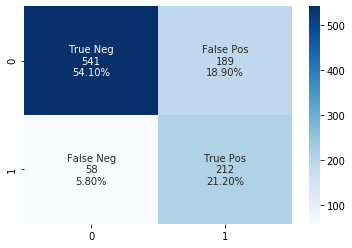

In [43]:
#• True Positive (TP) : Actual observation is positive, and it is predicted to be positive.
#• False Negative (FN) : Actual Observation is positive, but it is predicted negative.
#• True Negative (TN) : Actual observation is negative, and it is predicted to be negative.
#• False Positive (FP) : Actual observation is negative, but is predicted positive.
# So we can see that if our model is performing correctly we should have higher count of True Positives and True Negatives
matrix = confusion_matrix(Y_test, prediction_values_logistic)
cells = ['True Neg','False Pos','False Neg','True Pos']
cell_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
cell_percent = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(cells,cell_counts,cell_percent)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

In [44]:
# Create the DNN Model
DNN_model = create_DNN_model()
# Here I have utilized the train model function which is an advantage of using an estimator to pass in the DNN model. 
# After tring with several hyperparams I have determined below hyperparams for which the model works correctly.
train_model(DNN_model, X_train, y_train, should_shuffle=True, steps = 2000, num_epochs=2000)
# Here again I have utilized the evaluate model function which is an advantage of using an estimator to pass in the trained DNN model
# The evaluate function returns various scoring metrics. In this case I have fetched only the accuracy on the validation set.
evaluate_model(DNN_model, X_val, y_val, should_shuffle=False, model_flag=1)

0.8102734

In [0]:
# To generate predictions on the unseen dataset we have.
prediction_values_DNN = model_predict(DNN_model, X_test)
# get the roc curve
fpr_DNN, tpr_DNN, thresholds = roc_curve(Y_test, 1 - np.array(prediction_values_DNN))

In [0]:
# Now I have translated the probability values to actual true/false labels. For this I have used a threshold of 0.7:
prediction_values_DNN = [1 if value < 0.7 else 0 for value in prediction_values_DNN]

Confusion Matrix(Deep Neural Network)

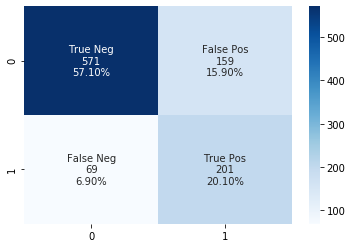

In [47]:
# We can see that the model has performed very well with the large count to True Positives and True Negatives along the diagonal.
matrix = confusion_matrix(Y_test, prediction_values_DNN)
cells = ['True Neg','False Pos','False Neg','True Pos']
cell_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
cell_percent = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(cells,cell_counts,cell_percent)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

In [48]:
# Create the Boosted Trees Model
boostTrees_model = create_boost_model()

# Here I have utilized the train model function again to pass in the BoostedTrees model. 
# After tring with several hyperparams I have determined below hyperparams for which the model works correctly.
train_model(boostTrees_model, X_train, y_train, should_shuffle=True, steps = 35, num_epochs = 35)
# Here again I have utilized the evaluate model function which is an advantage of using an estimator to pass in the trained 
# BoostedTrees model. The evaluate function returns various scoring metrics. In this case I have fetched only the accuracy 
# on the validation set.
evaluate_model(boostTrees_model, X_val, y_val, should_shuffle=False, model_flag=2)

0.78127587

In [0]:
# To generate predictions on the unseen dataset we have.
prediction_values_boostTrees = model_predict(boostTrees_model, X_test)
# get the roc curve
fpr_bstree, tpr_bstree, thresholds = roc_curve(Y_test, 1 - np.array(prediction_values_boostTrees))

In [0]:
# Now I have translated the probability values to actual true/false labels. For this I have used a threshold of 0.7:
prediction_values_boostTrees = [1 if value < 0.7 else 0 for value in prediction_values_boostTrees]

Confusion Matrix(Boosted Trees Classifier)

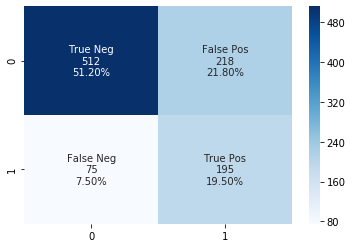

In [51]:
matrix = confusion_matrix(Y_test, prediction_values_boostTrees)
cells = ['True Neg','False Pos','False Neg','True Pos']
cell_counts = ['{0:0.0f}'.format(value) for value in matrix.flatten()]
cell_percent = ['{0:.2%}'.format(value) for value in matrix.flatten()/np.sum(matrix)]
labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in zip(cells,cell_counts,cell_percent)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(matrix, annot=labels, fmt='', cmap='Blues')

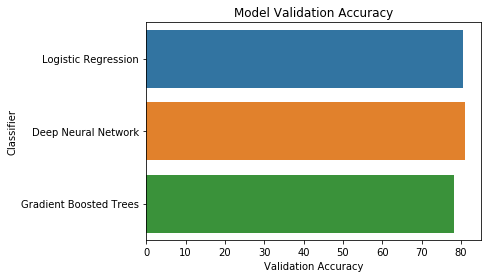

In [52]:
# From below plot we can see that Linear Classifier and Deep Neural Networks have performed slightly better on our held out 
# Validation set.
classifier_acc = pd.DataFrame(record, columns=model_metric_cols)
plt.xlabel('Validation Accuracy')
plt.title('Model Validation Accuracy')
sns.set_color_codes("muted")
sns.barplot(x='Validation Accuracy', y='Classifier', data=classifier_acc)

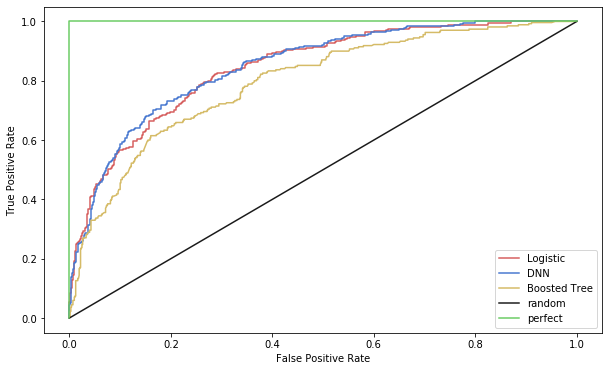

In [53]:
# Accuracy is just how many predictions we got right divided by the total number of examples. It might not be the best metric 
# here since we have an imbalanced dataset since if we predict every example as zero we can get 73% accuracy as per our data. 
# Hence I have plotted the ROC Curve. The ROC AUC is the area under the curve when plotting the (normalized) true positive rate 
# (x-axis) and the false positive rate (y-axis). This gives us a better metric for choosing our model. From the below plot I believe
# Deep Neural Network performs slightly better than the Linear Classifier and hence it will be my preferred choice of model.
plt.figure(figsize=(10, 6))
plt.plot(fpr_logistic, tpr_logistic,'r-',label = 'Logistic')
plt.plot(fpr_DNN,tpr_DNN,'b-', label= 'DNN')
plt.plot(fpr_bstree,tpr_bstree,'y-', label= 'Boosted Tree')
plt.plot([0,1],[0,1],'k-',label='random')
plt.plot([0,0,1,1],[0,1,1,1],'g-',label='perfect')
plt.legend()
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()